## 位置エンコーディング
+ x, y, c
+ C・・・周期
+ X, Y・・・周期 $ \frac{2i}{C/2} $ を持つベクトルのある位置 $ Wy + x $ を指定

In [34]:
# Standard
import os
import sys
import glob
from collections import deque
import random
import copy
from copy import deepcopy
from typing import Callable, Sequence, Tuple, Union, List, Dict, Optional
import json
import math
import shutil
from pathlib import Path

# 3rd-party
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch import optim

# torchvision
import torchvision
from torchvision import transforms as T
from torchvision.transforms import functional as TF
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import sigmoid_focal_loss, batched_nms
from torchvision.ops.misc import FrozenBatchNorm2d

# Coco
from pycocotools.cocoeval import COCOeval


+ $ p_{2i} = sin(\frac{2 \pi x}{T^\frac{2i}{C/2}}) $
+ $ p_{2i+1} = cos(\frac{2 \pi y}{T^\frac{2i}{C/2}}) $
+ $ i= \{0, \cdots \frac{C}{2} \} $

In [2]:
# 位置エンコーディング
C = 128
T = 10000
dim_t = torch.arange(0, C, 2, dtype=torch.float32)
dim_t = T ** (dim_t / C)
# print(dim_t)
print(dim_t.shape)

# H = W = 64
# x_img = torch.rand(size=(H, W))
# print(x_img)
# print(x_img.shape)


dim_t = dim_t.repeat_interleave(2)
# print(dim_t)
print(dim_t.shape)

img = torch.ones(size=(64,64))
# print(img)
print(img.shape)
x_pos_2d = img.cumsum(dim=1).unsqueeze(dim=0)
# print(x_pos_2d)
print('x_pos_2d.shape', x_pos_2d.shape)
y_pos_2d = img.cumsum(dim=0).unsqueeze(dim=0)
# print(y_pos_2d)
print('y_pos_2d.shape', y_pos_2d.shape)

x_encoding = x_pos_2d / dim_t.view(C, 1, 1)
# print(x_encoding)
print('x_encoding.shape', x_encoding.shape)
y_encoding = y_pos_2d / dim_t.view(C, 1, 1)
# print(y_encoding)
print('y_encoding.shape', y_encoding.shape)

x_encoding[:, ::2] = x_encoding[:, ::2].sin()
x_encoding[:, 1::2] = x_encoding[:, 1::2].cos()
# print(x_encoding)
print('x_encoding.shape', x_encoding.shape)

x_enc_max = x_encoding.max()
print('x_enc_max', x_enc_max)

y_encoding[:, ::2] = y_encoding[:, ::2].sin()
y_encoding[:, 1::2] = y_encoding[:, 1::2].cos()
# print(y_encoding)
print('y_encoding.shape', y_encoding.shape)

y_enc_max = y_encoding.max()
print('y_enc_max', y_enc_max)



for c in range(C//2):
    x_sin_enc = x_encoding[c, ...].numpy()
    x_cos_enc = x_encoding[c+1, ...].numpy()
    y_sin_enc = y_encoding[c, ...].numpy()
    y_cos_enc = y_encoding[c+1, ...].numpy()

    fig, axes = plt.subplots(1, 4, sharex=True, sharey=True)
    axes[0].imshow(x_sin_enc)#, cmap='Greys')
    axes[0].set_title(f"C={c}, x_sin_enc")

    axes[1].imshow(x_cos_enc)#, cmap='Greys')
    axes[1].set_title(f"C={c}, x_cos_enc")

    axes[2].imshow(y_sin_enc)#, cmap='Greys')
    axes[2].set_title(f"C={c}, y_sin_enc")

    axes[3].imshow(y_cos_enc)#, cmap='Greys')
    axes[3].set_title(f"C={c},y_cos_enc")

    fig.tight_layout()


plt.show()



Output hidden; open in https://colab.research.google.com to view.

In [3]:
tmp_randn = torch.randn(size=(4,4), dtype=torch.float32)
print(tmp_randn)
print(tmp_randn.size())

# tmp_np = tmp_randn.numpy() > 0.5
# print(tmp_np)
# print(tmp_np.shape)

tmp_mask = tmp_randn.ge(0.5)
print(tmp_mask)
x_mask = tmp_mask.cumsum(1, dtype=torch.float32)
print(x_mask)

tensor([[-0.8089,  0.5182,  0.5962, -0.7350],
        [ 1.7871,  0.9999, -0.8102, -0.2459],
        [-1.6010,  0.0261,  1.6522,  0.5730],
        [-1.2541,  0.4685, -0.7797, -0.4609]])
torch.Size([4, 4])
tensor([[False,  True,  True, False],
        [ True,  True, False, False],
        [False, False,  True,  True],
        [False, False, False, False]])
tensor([[0., 1., 2., 2.],
        [1., 2., 2., 2.],
        [0., 0., 1., 2.],
        [0., 0., 0., 0.]])


In [4]:
class PositionalEncoding:
    '''
    位置エンコーディング生成クラス
    eps : 0割防止の小さい値
    temperature: 温度定数
    '''
    def __init__(self,
                 eps: float = 1e-6, temperature: int = 10000):
        self.eps = eps
        self.temperature = temperature

    '''
    位置エンコーディングを生成する関数
    x: 特徴マップ [B, C, H, W]
    mask: 画像領域を示すマスク [B, H, W] Batchの各値は画像サイズが異なるため. 画像領域: false, 非画像領域: true
    '''
    @torch.no_grad()
    def __call__(self, x: torch.Tensor,
                 mask: torch.Tensor) -> torch.Tensor:
        # 位置エンコーディングのチャネル数は入力の半分として
        # x方向のエンコーディングとy方向のエンコーディングを用意して
        # それらを連結することで入力のチャネル数に合わせる
        num_pos_channels = x.shape[1] // 2

        # 温度定数の指数
        dim_t = torch.arange(0, num_pos_channels, 2,
                             dtype=x.dtype, device=x.device)

        # sinとcosを計算するために値を複製
        # [0, 2, ...] -> [0,0,2,2...]
        dim_t = dim_t.repeat_interleave(2)

        # sinとcosへの入力の分母となるT^{2i / d}を計算
        dim_t /= num_pos_channels
        dim_t = self.temperature ** dim_t # (C,)

        # マスクされていない領域の座標を計算
        inverted_mask = ~mask
        y_encoding = inverted_mask.cumsum(1, dtype=torch.float32) # (B, H dim=1, W)
        x_encoding = inverted_mask.cumsum(2, dtype=torch.float32) # (B, H, W dim=2)

        # 座標を0-1に正規化して2PIを掛ける
        y_encoding = 2 * math.pi * y_encoding / (y_encoding.max(dim=1, keepdim=True)[0] + self.eps)
        x_encoding = 2 * math.pi * x_encoding / (x_encoding.max(dim=2, keepdim=True)[0] + self.eps)

        # 座標を保持するテンソルにチャネル軸を追加して
        # チャネル軸方向にdim_tで割る
        # 偶数チャネルはsin 奇数チャネルはcosの位置エンコーディングになる
        y_encoding = y_encoding.unsqueeze(dim=1) # (B, H, W) => (B, C, H, W)
        y_encoding /= dim_t.view(num_pos_channels, 1, 1) # (C,) => (C, 1, 1)
        y_encoding[:, ::2] = y_encoding[:, ::2].sin()
        y_encoding[:, 1::2] = y_encoding[:, 1::2].cos()

        x_encoding = x_encoding.unsqueeze(dim=1) # (B, H, W)
        x_encoding /= dim_t.view(num_pos_channels, 1, 1)
        x_encoding[:, ::2] = x_encoding[:, ::2].sin()
        x_encoding[:, 1::2] = x_encoding[:, 1::2].cos()

        # 位置エンコーディングを連結して出力
        return torch.cat([x_encoding, y_encoding], dim=1)



## Transformerエンコーダ層

In [5]:
class TransformerEncoderLayer(nn.Module):
    '''
    dim_hidden: 特徴量の次元
    num_heads: MHSAのヘッド数
    dim_feedforward: FNNの中間特徴量の次元
    dropout: ドロップアウト率
    '''
    def __init__(self,
                 dim_hidden: int = 256,
                 num_heads: int = 8,
                 dim_feedforward: int = 2048,
                 dropout: float = 0.1):
        super().__init__()
        self.dim_hidden = dim_hidden
        self.num_heads = num_heads
        self.dim_feedforward = dim_feedforward
        self.dropout = dropout

        # 自己アテンションブロック
        self.self_attn = nn.MultiheadAttention(dim_hidden, num_heads, dropout=dropout)
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(dim_hidden)

        # FNN
        self.fnn = nn.Sequential(
            nn.Linear(dim_hidden, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, dim_hidden)
        )

        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(dim_hidden)

    '''
    L: 特徴量数
    B: バッチサイズ
    D: 特徴量の次元
    ---
    x: [L, B, D]
    pos_encoding: [L, B, D]
    mask: [B, L]
    '''
    def forward(self,
                x: torch.Tensor,
                pos_encoding: torch.Tensor,
                mask: torch.Tensor):
        # クエリとキーに位置エンコーディングを加算
        q = k = x + pos_encoding

        # attn_maskでAttentionマップの有効/無効を設定する
        x_attn, attn_map = self.self_attn(q,
                                          k,
                                          value=x,
                                          attn_mask=mask) # mask: 有効値: False, 無効値: True
        x = x + self.dropout1(x_attn)
        x = self.norm1(x)

        x_fnn  = self.fnn(x)
        x = x + self.dropout2(x_fnn)
        x = self.norm2(x)

        return x

## Transformerデコーダ層

In [6]:
class TransformerDecoderLayer(nn.Module):
    '''
    dim_hidden: 特徴量の次元
    num_heads: MHSAのヘッド数
    dim_feedforward: FNNの中間特徴量の次元
    dropout: ドロップアウト率
    '''
    def __init__(self,
                 dim_hidden: int = 256,
                 num_heads: int = 8,
                 dim_feedforward: int = 2048,
                 dropout: float = 0.1):
        super().__init__()

        # 自己アテンションブロック
        self.self_attn = nn.MultiheadAttention(dim_hidden, num_heads, dropout=dropout)
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(dim_hidden)

        # 物体特徴量と特徴マップの特徴量の交差アテンション
        self.crs_attn = nn.MultiheadAttention(dim_hidden, num_heads, dropout=dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(dim_hidden)

        # FNN
        self.fnn = nn.Sequential(
            nn.Linear(dim_hidden, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, dim_hidden)
        )
        self.dropout3 = nn.Dropout(dropout)
        self.norm3 = nn.LayerNorm(dim_hidden)

    '''
    h: 物体特徴量 [Q, B, D]
    query_embed: 物体クエリ埋め込み [Q, B, D]
    x: 特徴マップの特徴量 [L, B, D]
    pos_encoding: 位置エンコーディング [L, B, D]
    mask: マスク [B, L]
    '''
    def forward(self,
                h: torch.Tensor,
                query_embed: torch.Tensor,
                x: torch.Tensor,
                pos_encoding: torch.Tensor,
                mask: torch.Tensor):

        # 物体クエリ埋め込みの自己アテンション
        # (物体特徴量の自己アテンション)
        q = k = h + query_embed
        x_attn, attn_map = self.self_attn(q, h, k)
        h = h + self.dropout1(x_attn)
        h = self.norm1(h)

        # 物体クエリ埋め込みと特徴マップの交差アテンション
        # (物体特徴量と特徴マップの交差アテンション)
        q = k = h + query_embed
        x_crs_attn, attn_crs_map = self.crs_attn(h + query_embed, # Q
                                                 x + pos_encoding, # K
                                                 x, # V
                                                 key_padding_mask=mask) # key_padding_maskは, cross_attention用のマスク

        h = h + self.dropout2(x_crs_attn)
        h = self.norm2(h)

        h2 = self.fnn(h)
        h = h + self.dropout3(h2)
        h = self.norm3(h)

        return h

## エンコーダとデコーダをまとめるTransformerブロック

In [7]:
class Transformer(nn.Module):
    '''
    dim_hidden: 特徴量の次元
    num_heads: MHSAのヘッド数
    num_encoder_layers: Transformerエンコーダ層の数
    num_decoder_layers: Transformerデコーダ層の数
    dim_feedforward: FNNの中間特徴量の次元
    dropout: ドロップアウト率
    '''
    def __init__(self,
                 dim_hidden: int = 256,
                 num_heads: int = 8,
                 num_encoder_layers: int = 3,
                 num_decoder_layers: int = 3,
                 dim_feedforward: int = 2048,
                 dropout: float = 0.1):
        super().__init__()

        # 複数のエンコーダ
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(dim_hidden,
                                    num_heads,
                                    dim_feedforward,
                                    dropout) for _ in range(num_encoder_layers)])

        # 複数のデコーダ
        self.decoder_layers = nn.ModuleList([
            TransformerDecoderLayer(dim_hidden,
                                    num_heads,
                                    dim_feedforward,
                                    dropout) for _ in range(num_decoder_layers)])

        self._reset_parameters()


    def _reset_parameters(self):
        # Xavierの初期化
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    '''
    x: 特徴マップ [B, C, H, W]
    pos_encoding: 位置エンコーディング [B, C, H, W]
    mask: マスク [B, H, W]
    query_embed: 物体クエリ埋め込み [Q, D]
    Q: クエリ数
    L: 特徴量数
    B: バッチサイズ
    '''
    def forward(self,
                x: torch.Tensor,
                pos_encoding: torch.Tensor,
                mask: torch.Tensor,
                query_embed: torch.Tensor):

        batch_size = x.shape[0]

        '''
        エンコーダやデコーダのMHSAのクエリ, キー, バリューは
        第0軸: 特徴量列軸
        第1軸: バッチ軸
        第2軸: チャネル軸
        [L, B, C]

        マスクは
        第0軸: バッチ軸
        第1軸: 特徴量列軸
        [B, L]

        である必要がある
        '''

        # 特徴マップ [B, C, H, W] -> [H*W, B, C]
        x = x.flatten(2).permute(2, 0, 1)

        # 位置エンコーディング [B, C, H, W] -> [H*W, B, C]
        pos_encoding = pos_encoding.flatten(2).permute(2, 0, 1)

        # マスク [B, H, W] -> [B, H*W]
        mask = mask.flatten(1)

        # 物体クエリ埋め込み [Q, C] -> [Q, B, C] (バッチ数だけ拡張)
        query_embed = query_embed.unsqueeze(1).expand(-1, batch_size, -1)

        '''
        各データをエンコーダ層とデコーダ層に入力するフェーズ
        '''
        # 特徴量マップxをより良い特徴量マップに変換する
        for layer in self.encoder_layers:
            x = layer(x, pos_encoding, mask)

        # 途中のデコーダ層の出力を保持
        hs = []
        h = torch.zeros_like(query_embed) # 初期値
        for layer in self.decoder_layers:
            h = layer(h, query_embed, x, pos_encoding, mask)
            hs.append(h)

        # デコーダ層の出力を第0軸で連結
        # Decoders * [Q, B, C] -> [Decoders, Q, B, C]
        hs = torch.stack(hs, dim=0)
        hs = hs.permute(0, 2, 1, 3) # [Decoders, B, Q, C]

        return hs


## Backborn(ResNet18)

In [8]:
from torchvision.ops.misc import FrozenBatchNorm2d


class BasicBlock(nn.Module):
    '''
    ResNet18における残差ブロック
    in_channels : 入力チャネル数
    out_channels: 出力チャネル数
    stride      : 畳み込み層のストライド
    '''
    def __init__(self, in_channels: int, out_channels: int,
                 stride: int=1):
        super().__init__()

        ''''' 残差接続 '''''
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = FrozenBatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, padding=1, bias=False)
        self.bn2 = FrozenBatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        ''''''''''''''''''''

        # strideが1より大きいときにスキップ接続と残差接続の高さと幅を
        # 合わせるため、別途畳み込み演算を用意
        self.downsample = None
        if stride > 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                FrozenBatchNorm2d(out_channels)
            )

    '''
    順伝播関数
    x: 入力, [バッチサイズ, チャネル数, 高さ, 幅]
    '''
    def forward(self, x: torch.Tensor):
        ''''' 残差接続 '''''
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        ''''''''''''''''''''

        if self.downsample is not None:
            x = self.downsample(x)

        # 残差写像と恒等写像の要素毎の和を計算
        out += x

        out = self.relu(out)

        return out


class ResNet18(nn.Module):
    '''
    ResNet18モデル
    '''
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = FrozenBatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.max_pool = nn.MaxPool2d(kernel_size=3,
                                     stride=2, padding=1)

        self.layer1 = nn.Sequential(
            BasicBlock(64, 64),
            BasicBlock(64, 64),
        )
        self.layer2 = nn.Sequential(
            BasicBlock(64, 128, stride=2),
            BasicBlock(128, 128),
        )
        self.layer3 = nn.Sequential(
            BasicBlock(128, 256, stride=2),
            BasicBlock(256, 256),
        )
        self.layer4 = nn.Sequential(
            BasicBlock(256, 512, stride=2),
            BasicBlock(512, 512),
        )

    '''
    順伝播関数
    x: 入力, [バッチサイズ, チャネル数, 高さ, 幅]
    '''
    def forward(self, x: torch.Tensor):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.layer1(x)
        c3 = self.layer2(x)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)

        return c3, c4, c5

## DETR

In [9]:
class DETR(nn.Module):
    '''
    DETRモデル(ResNet18)
    num_queires: 物体クエリ埋め込みの数
    dim_hidden: Transformerで処理する際の特徴量次元
    num_heads: MHSAのヘッド数
    num_encoder_layers: Transformerエンコーダ層の数
    num_decoder_layers: Transformerデコーダ層の数
    dim_feedforward: FNNの中間特徴量の次元
    dropout: ドロップアウト率
    num_class: 物体クラス数
    '''
    def __init__(self,
                 num_queries: int,
                 dim_hidden: int,
                 num_heads: int,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 dim_feedforward: int,
                 dropout: float,
                 num_class: int):
        super().__init__()

        self.backbone = ResNet18()

        # バックボーンネットワークの特徴マップのチャネル数を
        # 減らすための畳み込み層
        self.proj = nn.Conv2d(512, dim_hidden, kernel_size=1)

        self.transformer = Transformer(dim_hidden,
                                       num_heads,
                                       num_encoder_layers,
                                       num_decoder_layers,
                                       dim_feedforward,
                                       dropout)

        # 分類ヘッド
        self.class_head = nn.Linear(dim_hidden, num_class + 1) # 背景クラスを追加

        # 矩形ヘッド
        self.box_head = nn.Sequential(
            nn.Linear(dim_hidden, dim_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(dim_hidden, dim_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(dim_hidden, 4)
        )

        # 位置エンコーディング
        self.positional_encoding = PositionalEncoding()

        # 物体クラス埋め込み
        self.query_embed = nn.Embedding(num_queries, dim_hidden)

    '''
    x: 入力画像: [B, C, H, W]
    mask: [B, H, W]. True: 有効, False: 無効
    '''
    def forward(self, x: torch.Tensor, mask: torch.Tensor):
        # バックボーンネットワークから第5レイヤーの特徴マップを取得
        x = self.backbone(x)[-1] # c3, c4, c5
        # チャネル数を減らす for Transformer
        x = self.proj(x)

        # 入力画像と同じ大きさを持つmaskを特徴マップの大きさにリサイズ
        # interpolate関数はbool型には対応していないため, 一旦, xと同じ型に変換
        mask = F.interpolate(mask.unsqueeze(1), size=x.shape[2:])[:, 0] # [B, c, *, *] -> [B, 1, *, *]
        mask = mask.to(torch.bool)

        pos_encoding = self.positional_encoding.generate(x, mask)

        # [デーコーダ数, B, Q, C]
        hs = self.transformer(x, pos_encoding, mask, self.query_embed.weight)

        preds_class = self.class_head(hs)
        preds_box = self.box_head(hs).sigmoid()

        return preds_class, preds_box




## 後処理

In [10]:
'''
矩形をxmin, ymin, xmax, ymaxからx, y, width, heightに変換する関数
boxes: 矩形集合, [矩形数 (任意の軸数), 4 (xmin, ymin, xmax, ymax)]
'''
def convert_to_xywh(boxes: torch.Tensor):
    wh = boxes[..., 2:] - boxes[..., :2]
    xy = boxes[..., :2] + wh / 2
    boxes = torch.cat((xy, wh), dim=-1)

    return boxes

'''
矩形をx, y, width, heightからxmin, ymin, xmax, ymaxに変換
boxes: 外接集合, [矩形数 (任意の軸数), 4 (x, y, width, height)]
'''
def convert_to_xyxy(boxes: torch.Tensor):
    xymin = boxes[..., :2] - boxes[..., 2:] / 2
    xymax = boxes[..., 2:] + xymin
    boxes = torch.cat((xymin, xymax), dim=-1)

    return boxes

'''
boxes1: 矩形集合, [矩形数, 4 (xmin, ymin, xmax, ymax)]
boxes2: 矩形集合, [矩形数, 4 (xmin, ymin, xmax, ymax)]
'''
def calc_iou(boxes1: torch.Tensor, boxes2: torch.Tensor):
    # 第1軸をunsqueezeし、ブロードキャストを利用することで
    # [矩形数, 1, 2] と[矩形数, 2]の演算結果が
    # [boxes1の矩形数, boxes2の矩形数, 2] となる

    # 積集合の左上の座標を取得
    intersect_left_top = torch.maximum(
        boxes1[:, :2].unsqueeze(1), boxes2[:, :2])
    # 積集合の右下の座標を取得
    intersect_right_bottom = torch.minimum(
        boxes1[:, 2:].unsqueeze(1), boxes2[:, 2:])

    # 積集合の幅と高さを算出し、面積を計算
    intersect_width_height = (
        intersect_right_bottom - intersect_left_top).clamp(min=0)
    intersect_areas = intersect_width_height.prod(dim=2)

    # それぞれの矩形の面積を計算
    areas1 = (boxes1[:, 2] - boxes1[:, 0]) * \
        (boxes1[:, 3] - boxes1[:, 1])
    areas2 = (boxes2[:, 2] - boxes2[:, 0]) * \
        (boxes2[:, 3] - boxes2[:, 1])

    # 和集合の面積を計算
    union_areas = areas1.unsqueeze(1) + areas2 - intersect_areas

    ious = intersect_areas / union_areas

    return ious, union_areas

In [11]:
'''
preds_class: 検出矩形クラス [B, Q, Class]
preds_box: 検出矩形 [B, Q, 4]
targets: ラベル
include_bg: 分類結果に背景を含めるか否かのフラグ
'''
@torch.no_grad()
def post_process(preds_class: torch.Tensor,
                 preds_box: torch.Tensor,
                 targets: dict,
                 include_bg: bool = False):
    # クラス確率
    probs = preds_class.softmax(dim=2)

    if include_bg:
        scores, labels = probs.max(dim=2) # Value, Index
    else:
        scores, labels = probs[:, :, :-1].max(dim=2)

    # (cx, cy, w, h) -> (min_x, min_y, max_x, max_y)
    boxes = convert_to_xyxy(preds_box)

    # 矩形をミニバッチのサンプル毎の画像の大きさに合わせる
    img_sizes = torch.stack([target['orig_size'] for target in targets])
    boxes[:, :, ::2] *= img_sizes[:, 0].view(-1, 1, 1)
    boxes[:, :, 1::2] *= img_sizes[:, 1].view(-1, 1, 1)

    return scores, labels, boxes


## 損失の計算

### Generalized IoU (GIoU) 損失
+ 2つの矩形を包含する矩形の面積から和集合の面積を引き, 2つの矩形を包含する矩形の面積との比率を計算する.
+ IoUからこの比率を引き算するとGIoU損失が得られる.
+ L1誤差やL2誤差よりも正確に予測矩形の重なり度合いを測るために導入された

In [12]:
'''
boxes1: 矩形集合 [矩形数, 4]
boxes2: 矩形集合 [矩形数, 4]
'''
def calc_giou(boxes1: torch.Tensor, boxes2: torch.Tensor):
    ious, union = calc_iou(boxes1, boxes2)

    # 2つの矩形を包含する最小の矩形の面積を計算
    left_top = torch.minimum(boxes1[:, :2].unsqueeze(1), boxes2[:, :2]) # (N, 1, 2) * (M, 2) -> (N, M, 2)
    right_bottom = torch.maximum(boxes1[:, 2:].unsqueeze(1), boxes2[:, 2:])
    width_height = (right_bottom - left_top).clamp(min=0)
    areas = width_height.prod(dim=2)

    return ious - (areas - union) / areas


### 検出矩形と正解矩形の割り当て
1. IoUだけでなく物体の予測確率なども考慮した総合的な割り当てを行う
2. 各々の正解矩形に対して検出矩形を1つだけ割り当てる必要がある
3. 1つの検出矩形が複数個の正解矩形に割り当てられないようにする
+ 上記1,2,3をコスト最小化による割り当て問題として解決する

### コスト最小化による割り当て問題の解決
+ コスト行列
+ 行列の行は, 割り当て元要素(検出矩形)
+ 行列の列は, 割り当て先要素(正解矩形)
+ 行列の(i,j)成分は, コスト
+ コスト最小化による割り当て問題では, 行あるいは列の全ての要素を重複なく割り当てたあとのコストの合計が最小になるようにする

### 割り当て問題の解法
+ 貪欲法(最小値探索) -> 真の最小化はできない
+ ハンガリアンアルゴリズム

ハンガリアンアルゴリズム

In [13]:
from scipy.optimize import linear_sum_assignment

'''
preds_class         : 検出矩形のクラス [B, Q, class]
preds_box           : 検出矩形の位置と大きさ [B, Q, 4 (x, y, w, h)]
targets             : ラベル
loss_weight_class   : コストを計算する際の分類コストの重み
loss_weight_box_l1  : コストを計算する際の矩形のL1コストの重み
loss_weight_box_giou: コストを計算する際の矩形のGIoUコストの重み
'''
@torch.no_grad()
def _hungarian_match(preds_class: torch.Tensor,
                     preds_box: torch.Tensor, targets: dict,
                     loss_weight_class: float=1.0,
                     loss_weight_box_l1: float=5.0,
                     loss_weight_box_giou: float=2.0):
    batch_size, num_queries = preds_class.shape[:2]

    # コスト計算を全てのサンプル一括で計算するために
    # 全てのサンプルの予測結果を一旦第0軸に並べる
    preds_class = preds_class.flatten(0, 1).softmax(dim=1) # [B, Q, class] -> [B*Q, class]
    preds_box = preds_box.flatten(0, 1)

    # 全てのサンプルの正解ラベル(矩形)も一旦第0軸に並べる
    targets_class = torch.cat([target['classes'] for target in targets])

    # 正解矩形の値を正規化された画像上の座標に変換
    targets_box = torch.cat([
        target['boxes'] / target['size'].repeat(2) for target in targets
    ]) # (min_x, min_y, max_x, max_y) / (w, h, w, h)

    '''
    検出矩形と正解矩形の割り当てはサンプル(入力画像)毎におこなうため,
    サンプル毎のコスト行列が必要だが, コスト行列は、
    全サンプルの検出矩形と正解矩形を一括[全サンプルの検出矩形数, 全サンプルの正解矩形数]でまとめて作成する.
    最後に, サンプル毎のコスト行列に分割する.
    この方法だとGPUを最大限使用できる.
    '''

    # 分類のコストは正解クラスの予測確率にマイナスをかけたもの
    # 正解クラスの予測確率が高ければ高いほどコストが小さくなる
    cost_class = -1 * preds_class[:, targets_class] # [0, 1, 3, 7, 5, ...] -> [N=BQ(検出ラベル), M(正解ラベル)]

    # 矩形回帰の1つ目のコストとなる予測結果と正解のL1誤差の計算
    # cdist関数は, N x KのテンソルとM x Kのテンソルを与えられたとき,
    # N x Mの各組合せでK個の要素を使ってL1誤差を計算し, そのL1誤差を保持したN x Mテンソルを返す.
    cost_box_l1 = torch.cdist(preds_box, convert_to_xywh(targets_box), p=1) # [N, K] x [M, K] -> [N, M]

    # 矩形回帰の2つ目のコストとなる予測結果と正解のGIoU損失の計算
    cost_box_giou = -1 * calc_giou(convert_xyxy(preds_box), targets_box) # [N, K]

    cost = loss_weight_class * cost_class + \
           loss_weight_box_l1 * cost_box_l1 + \
           loss_weight_box_giou * cost_box_giou

    # 一括で計算していたコストをサンプル毎に分解するため軸を変更
    # 検出矩形の軸を分解して、
    # [バッチサイズ、クエリ数、全サンプルの正解数]という軸構成になる
    cost = cost.view(batch_size, num_queries, -1)

    # SciPyのlinear_sum_assignment関数を適用するためCPUへ転送
    cost = cost.to('cpu')

    # 各サンプルの正解矩形数を計算
    sizes = [len(target['classes']) for target in targets]

    '''
    各サンプル毎の[検出矩形, 正解矩形]の組のコスト行列に分解する
    '''
    indices = []
    # 第2軸を各サンプルの正解矩形数で分解し, バッチ軸でサンプルを
    # 指定することで, 各サンプルのコスト行列を取得
    for batch_id, c in enumerate(cost.split(sizes, dim=2)):
        c_batch = c[batch_id] # コスト行列

        # ハンガリアンアルゴリズムによる予測結果と正解のマッチング
        # クエリのインデックスと正解のインデックスを得る
        pred_indices, target_indices = linear_sum_assignment(c_batch)

        indices.append(
            (torch.tensor(pred_indices, dtype=torch.int64),
             torch.tensor(target_indices, dtype=torch.int64))
        )

    return indices




並べ替えインデックス

In [14]:
'''
indices : ハンガリアンアルゴリズムにより得られたインデックス
'''
def _get_pred_permutation_index(indices: Sequence[Tuple[torch.Tensor]]):
    # マッチした予測結果のバッチインデックス(サンプルインデックス)を1つの軸に並べる
    batch_indices = torch.cat(
        [torch.full_like(pred_indices, i) for i, (pred_indices, _) in enumerate(indices)]
    )

    # マッチした予測結果(検出矩形)のインデックスを1つの軸に並べる
    pred_indices = torch.cat([pred_indices for (pred_indices, _) in indices])

    return batch_indices, pred_indices

### 損失

分類損失

In [15]:
'''
preds: 検出矩形のクラス [B, Q, class + 1]
targets: ラベル
indices: ハンガリアンアルゴリズムにより得られたインデックス
background_weight: 背景クラスの交差エントロピー誤差の重み
'''
def _class_loss_func(preds: torch.Tensor,
                     targets: dict,
                     indices: List[Tuple[torch.Tensor]],
                     background_weight: float):
    '''
    正解矩形を割り当てられた検出矩形には、正解クラスによる交差エントロピー誤差を計算.
    正解矩形を割り当てられなかった検出矩形に対しては、背景クラスによる交差エントロピー誤差を計算する
    '''
    pred_indices = _get_pred_permutation_index(indices) # e.g. ([0,0,0,1,1,1], [2,1,0,0,2,1])

    # 物体クラス軸の最後の次元が背景クラス
    background_id = preds.shape[2] - 1

    # 正解ラベルとなるテンソルの作成
    # [B, Q]のテンソルを作成して背景IDを設定
    targets_class = preds.new_full(preds.shape[:2], background_id, dtype=torch.int64)

    # マッチした予測悔過kの部分に正解ラベルの物体クラスIDを代入
    targets_class[pred_indices] = torch.cat([
        target['classes'][target_indices] for target, (_, target_indices) in zip(targets, indices)])

    # 背景クラスの正解数が多く, クラス毎の正解数に不均衡が生じるため
    # 背景クラスの重みを下げる
    weights = preds.new_ones(preds.shape[:2])
    weights[background_id] = background_weight

    # 交差エントロピー誤差の計算
    loss = F.cross_entropy(preds, targets_class, weight=weights)

    return loss


矩形損失

In [16]:
'''
preds: 検出矩形の位置と大きさ [B, Q, 4(x,y,w,h)]
targets: ラベル
indices: ハンガリアンアルゴリズムにより得られたインデックス
'''
def _box_loss_func(preds: torch.Tensor,
                   targets: dict,
                   indices: List[Tuple[torch.Tensor]]):
    pred_indices = _get_pred_permutation_index(indices)

    # マッチした予測結果の抽出
    preds = preds[pred_indices]

    # マッチした正解を抽出
    targets_box = torch.cat([
        target['boxes'][target_indices] for target, (_, target_indices) in zip(targets, indices)])

    # 0除算防止
    num_boxes = max(1, targets_box.shape[0])

    # L1誤差の計算
    loss_l1 = F.l1_loss(preds, convert_to_xywh(targets_box), reduction='sum') / num_boxes

    # マッチした予測結果と正解でGIoU損失を計算
    gious = calc_giou(preds, targets_box)
    loss_giou = (1 - gious.diag()).sum() / num_boxes

    return loss_l1, loss_giou


損失計算フロー

In [17]:
'''
preds_class: 検出矩形のクラス [B, Q, class + 1]
preds_box:  検出矩形の位置と大きさ [B, Q, 4(x,y,w,h)]
targets: ラベル
loss_weight_class: 分類コストの重み
loss_weight_box_l1: 矩形のL1コストの重み
loss_weight_box_giou: 矩形のGIoUコストの重み
'''
def loss_func(preds_class: torch.Tensor,
              preds_box: torch.Tensor,
              targets: dict,
              loss_weight_class: float = 1.0,
              loss_weight_box_l1: float = 5.0,
              loss_weight_box_giou: float = 2.0,
              background_weight: float = 0.1):

    indices = _hungarian_match(preds_class, preds_box, targets,
                loss_weight_class, loss_weight_box_l1, loss_weight_box_giou)

    loss_class = loss_weight_class * _class_loss_func(preds_class,
                                                      targets,
                                                      targets,
                                                      indices,
                                                      background_weight)

    loss_box_l1, loss_box_giou = _box_loss_func(preds_box,
                                                targets,
                                                indices)

    loss_box_l1 = loss_weight_box_l1 * loss_box_l1
    loss_box_giou = loss_weight_box_giou * loss_box_giou

    return loss_class, loss_box_l1, loss_box_giou


In [18]:
'''
batch: CocoDetectionからサンプルした複数の画像とラベルをまとめたもの
'''
def collate_func(batch: Sequence[Tuple[Union[torch.Tensor, dict]]]):
    # ミニバッチの中の画像で最大の高さと幅を取得
    max_height = 0
    max_width = 0
    for img, _ in batch:
        height, width = img.shape[1:]
        max_height = max(max_height, height)
        max_width = max(max_width, width)

    imgs = batch[0][0].new_zeros((len(batch), 3, max_height, max_width))
    # 真偽値を保持するマスクのテンソルは真の値で初期化
    masks = batch[0][0].new_ones((len(batch), max_height, max_width), dtype=torch.bool)
    targets = []
    for i, (img, target) in enumerate(batch):
        height, width = img.shape[1:]
        imgs[i, :, :height, :width] = img
        # 画像領域は偽
        masks[i, :height, :width] = False
        targets.append(target)

    return imgs, masks, targets

### 学習

パラメータ

In [19]:
class ConfigTrainEval:
    '''
    ハイパーパラメータとオプションの設定
    '''
    def __init__(self):
        self.img_directory = '/content/val2014'            # 画像があるディレクトリ
        self.anno_file = '/content/drive/MyDrive/ColabNotebooks/Book_DL_Image_Recognition/data/coco2014/instances_val2014_small.json' # アノテーションファイルのパス
        self.save_file = '/content/drive/MyDrive/ColabNotebooks/Book_DL_Image_Recognition/model/detr.pth' # パラメータを保存するパス
        self.val_ratio = 0.2                               # 検証に使う学習セット内のデータの割合
        self.num_epochs = 100                              # 学習エポック数
        self.lr_drop = 90                                  # 学習率を減衰させるエポック
        self.val_interval = 5                              # 検証を行うエポック間隔
        self.lr = 1e-4                                     # 学習率
        self.lr_backbone = 1e-5                            # バックボーンネットワークの学習率
        self.weight_decay = 1e-4                           # 荷重減衰
        self.clip = 0.1                                    # 勾配のクリップ上限
        self.num_queries = 100                             # 物体クエリ埋め込みのクエリベクトル数
        self.dim_hidden = 256                              # Transformer内の特徴量次元
        self.num_heads = 8                                 # マルチヘッドアテンションのヘッド数
        self.num_encoder_layers = 6                        # Transformerエンコーダの層数
        self.num_decoder_layers = 6                        # Transformerデコーダの層数
        self.dim_feedforward = 2048                        # Transformer内のFNNの中間特徴量次元
        self.dropout = 0.1                                 # Transformer内のドロップアウト率
        self.loss_weight_class = 1                         # 分類損失の重み
        self.loss_weight_box_l1 = 5                        # 矩形回帰のL1誤差の重み
        self.loss_weight_box_giou = 2                      # 矩形回帰のGIoU損失の重み
        self.background_weight = 0.1                       # 背景クラスの重み
        self.moving_avg = 100                              # 移動平均で計算する損失と正確度の値の数
        self.batch_size = 8                                # バッチサイズ
        self.num_workers = 2                               # データローダに使うCPUプロセスの数
        self.device = 'cuda'                               # 学習に使うデバイス

データセットの準備

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


データセットの分割関数

In [21]:
'''
データセットを分割するための2つの排反なインデックス集合を生成する関数
dataset: 分割対象のデータセット
ratio: 1つ目のセットに含めるデータ量の割合
random_seed: シード値
'''
def generate_subset(dataset: Dataset,
                    ratio: float,
                    random_seed: int=0):
    # サブセットの大きさ
    size = int(len(dataset) * ratio)

    indices = list(range(len(dataset)))

    # シャッフル
    random.seed(random_seed)
    random.shuffle(indices)

    indices1, indices2 = indices[:size], indices[size:]

    return indices1, indices2

データセット COCO2014
+ 約33万枚の画像データ
+ インターネットから集められた日常画像
+ 物体検出用のアノテーションは80クラスの外接矩形
+ その他, 作者によるセグメンテーション, 姿勢推定など
+ 2014年時点 学習用8万枚, 検証用4万枚 テスト用4万枚

val2014.zipをダウンロード
+ 検証用のみ使う
+ 1万枚
+ URL: http://images.cocodataset.org/zips/val2014.zip


GoogleDriveに保存先を変更

In [22]:
!wget http://images.cocodataset.org/zips/val2014.zip

--2025-01-20 05:59:17--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.182.74.17, 54.231.168.161, 3.5.24.180, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.182.74.17|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘val2014.zip’

val2014.zip         100%[===================>]   6.19G  17.9MB/s    in 6m 18s  

2025-01-20 06:05:35 (16.8 MB/s) - ‘val2014.zip’ saved [6645013297/6645013297]



In [23]:
!unzip val2014.zip

ストリーミング出力は最後の 5000 行に切り捨てられました。
 extracting: val2014/COCO_val2014_000000535608.jpg  
 extracting: val2014/COCO_val2014_000000279145.jpg  
 extracting: val2014/COCO_val2014_000000243495.jpg  
 extracting: val2014/COCO_val2014_000000225791.jpg  
 extracting: val2014/COCO_val2014_000000428067.jpg  
 extracting: val2014/COCO_val2014_000000059383.jpg  
 extracting: val2014/COCO_val2014_000000558498.jpg  
 extracting: val2014/COCO_val2014_000000376123.jpg  
 extracting: val2014/COCO_val2014_000000191304.jpg  
 extracting: val2014/COCO_val2014_000000171062.jpg  
 extracting: val2014/COCO_val2014_000000014549.jpg  
 extracting: val2014/COCO_val2014_000000121152.jpg  
 extracting: val2014/COCO_val2014_000000276596.jpg  
 extracting: val2014/COCO_val2014_000000029431.jpg  
 extracting: val2014/COCO_val2014_000000036349.jpg  
 extracting: val2014/COCO_val2014_000000502055.jpg  
 extracting: val2014/COCO_val2014_000000438848.jpg  
 extracting: val2014/COCO_val2014_000000364973.jpg  
 extracting: v

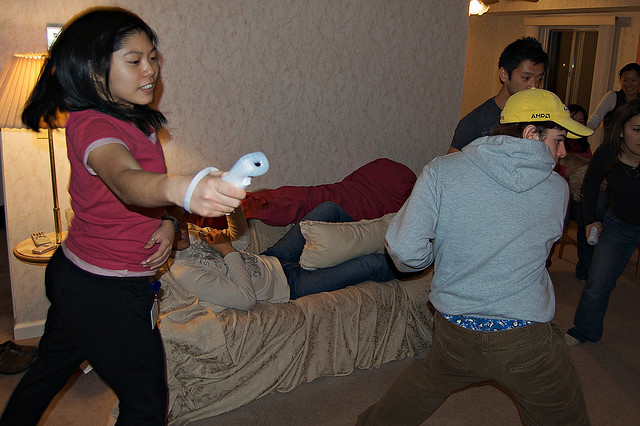

In [24]:
# お試し
from IPython.display import Image, display
ws_dir: str = os.getcwd()
file_path: str = os.path.join(ws_dir, f"val2014/COCO_val2014_000000441814.jpg")
display(Image(file_path))

アノテーションデータのLoad
+ 人と車の2種類
+ instances_val2014_small.json

独自のCocoDetectionデータセットクラス

In [25]:
class CocoDetection(torchvision.datasets.CocoDetection):
    '''
    物体検出用COCOデータセット読み込みクラス
    img_directory: 画像ファイルが保存されているディレクトリパス
    anno_file: アノテーションファイル
    transforms: データ拡張と整形を行うクラスインスタンス
    '''
    def __init__(self,
                 img_directory: str,
                 anno_file: str,
                 transform: Callable=None,
                 ):
        super().__init__(img_directory, anno_file)

        self.transform = transform

        # カテゴリIDに欠番があるため、それを埋めてクラスIDを割り当て
        self.classes = []
        # 元々のクラスIDと新しく割り当てたクラスIDを相互に変換するためのマッピング
        self.coco_to_pred = {}
        self.pred_to_coco = {}
        for i, category_id in enumerate(sorted(self.coco.cats.keys())):
            self.classes.append(self.coco.cats[category_id]['name'])
            # category_id: 欠番のある1から始まるCocoラベル
            # i: 0から始まる再割り当てラベル
            self.coco_to_pred[category_id] = i
            self.pred_to_coco[i] = category_id

    '''
    データ取得関数
    idx: サンプルを示すインデックス
    '''
    def __getitem__(self,
                    idx: int,
                    ):
        # print('__getitem__のオーバーロード')

        # imgはPIL.Image
        pil_img, target = super().__getitem__(idx)

        # 親クラスのコンストラクタでself.idsに
        # 画像IDが格納されているのでそれを取得
        img_id = self.ids[idx]

        # 物体の集合を1つの矩形でアノテーションしている物を除外
        # アノテーション(jsonに`iscrowd`がないもの or iscrowd==0のもの)
        target = [obj for obj in target
                  if 'iscrowd' not in obj or obj['iscrowd'] == 0]

        # 学習用に該当画像に映る物体のクラスIDと矩形を取得
        # クラスIDはコンストラクタで新規に割り当てたIDに変換
        classes = torch.tensor(
            [self.coco_to_pred[obj['category_id']] for obj in target],
            dtype=torch.int64)
        boxes = torch.tensor(
            [obj['bbox'] for obj in target],
            dtype=torch.float32)

        # 矩形が0個の時, boxes.shape == [0]となってしまうため,
        # 第一軸に4を追加して軸数と第二軸の次元を合わせる
        if boxes.shape[0] == 0:
            boxes = torch.zeros((0, 4)) # torch.size((0,4))

        width, height = pil_img.size # PIL.Image
        # min_x, min_y, width, height => min_x, min_y, max_x, max_y
        boxes[:, 2:] += boxes[:, :2] # (正解矩形数, 4)

        # 矩形が画像領域内に収まるように値をクリッピング
        boxes[:, ::2] = boxes[:, ::2].clamp(min=0, max=width)
        boxes[:, 1::2] = boxes[:, 1::2].clamp(min=0, max=height)

        # ↑ ここまでで、1枚の画像から正解矩形データを複数枚抜き出したことになる

        # 学習のための正解データを用意
        # クラスIDや矩形など渡すものが多岐にわたるので、辞書で用意
        target = {
            'image_id': torch.tensor(img_id, dtype=torch.int64),
            'classes': classes,
            'boxes': boxes, # (bboxes, 4)
            'size': torch.tensor((width, height), dtype=torch.int64),
            'orig_size': torch.tensor((width, height), dtype=torch.int64),
            'orig_img': torch.tensor(np.asarray(pil_img))
        }

        # print('type(target) at __getitem__ of CocoDetection', type(target))

        # データ拡張と整形
        if self.transform is not None:
            pil_img, target = self.transform(pil_img, target)

        return pil_img, target

    '''
    モデルで予測されたクラスIDからCOCOのクラスIDに変換する関数
    label: 予測されたクラスID
    '''
    def to_coco_label(self, label: int):
        return self.pred_to_coco[label]

In [26]:
# お試し
boxes = torch.zeros((0, 4)) # (4,)ではない
print(boxes.size())
print(boxes.shape)
print(boxes.numpy().shape)
print(boxes.numpy())
import numpy as np
vec1 = np.zeros((4,))
print(vec1.shape)
print(vec1)
vec2 = np.zeros((0,4))
print(vec2.shape)
print(vec2)

torch.Size([0, 4])
torch.Size([0, 4])
(0, 4)
[]
(4,)
[0. 0. 0. 0.]
(0, 4)
[]


データ拡張

In [27]:
'''水平反転'''
class RandomHorizontalFlip:

    def __init__(self, prob: float=0.5):
        self.prob = prob

    def __call__(self,
                 pil_img: Image,
                 target: dict,
                 ):
        if random.random() < self.prob:
            pil_img = TF.hflip(pil_img)

        # 正解矩形をx軸方向に反転
        # 制約式: max_x - min_x = width
        # min_x -> width - max_x
        # max_x -> width - min_x
        width = pil_img.size[0]
        # print("type(target)", type(target))
        # print('target', target)
        target['boxes'][:, [0, 2]] = width - target['boxes'][:, [2, 0]]

        return pil_img, target

'''クロップ'''
class RandomSizeCrop:
    '''
    scale: 切り抜き前に対する切り抜き後の画像面積の下限と上限
    ratio: 切り抜き後の画像のアスペクト比の下限と上限
    '''
    def __init__(self,
                 scale: Sequence[float],
                 ratio: Sequence[float],
                 ):
        self.scale = scale
        self.ratio = ratio

    '''
    無作為に画像を切り抜く
    '''
    def __call__(self,
                 pil_img: Image,
                 target: dict,
                 ):
        width, height = pil_img.size

        # 切り抜く領域の左上の座標と幅および高さを取得
        # 切り抜く領域はscaleとratioの下限と上限に従う
        top, left, cropped_height, cropped_width = \
            T.RandomResizedCrop.get_params(pil_img,
                                          self.scale,
                                          self.ratio)
        # 左上の座標と幅および高さで指定した領域を切り抜き
        pil_img = TF.crop(pil_img, top, left, cropped_height, cropped_width)

        # 原点がx=left,y=topになるように矩形座標を平行移動
        # (min_x, min_y, max_x, max_y)
        target['boxes'][:, ::2] -= left # min_x, max_x
        target['boxes'][:, 1::2] -= top # min_y, max_y

        # 矩形の座標が切り抜き後に領域外に出る場合は座標をクリップする
        target['boxes'][:, ::2] = \
            target['boxes'][:, ::2].clamp(min=0) # min_x, max_x
        target['boxes'][:, 1::2] = \
            target['boxes'][:, 1::2].clamp(min=0) # min_y, max_y
        target['boxes'][:, ::2] = \
            target['boxes'][:, ::2].clamp(max=cropped_width) # min_x, max_x
        target['boxes'][:, 1::2] = \
            target['boxes'][:, 1::2].clamp(max=cropped_height) # min_y, max_y

        # 幅と高さが0より大きくなる矩形のみを保持(max_x > min_x & max_y > min_y)
        # (矩形数=画像内のインスタンス数, 1)
        keep = (target['boxes'][:, 2] > target['boxes'][:, 0]) & \
               (target['boxes'][:, 3] > target['boxes'][:, 1]) # マスク
        target['classes'] = target['classes'][keep]
        target['boxes'] = target['boxes'][keep]

        # 切り抜き後の画像の大きさを保持
        target['size'] = torch.tensor([cropped_width, cropped_height], dtype=torch.int64)

        return pil_img, target

'''リサイズ'''
class RandomResize:
    '''
    無作為に画像をアスペクト比を保持してリサイズするクラス
    min_sizes: 短辺の長さの候補、この中から無作為に長さを抽出
    max_size :  長辺の長さの最大値
    '''
    def __init__(self, min_sizes: Sequence[int], max_size: int):
        self.min_sizes = min_sizes
        self.max_side = max_size


    def _get_target_size(self,
                         min_side: int, # 短辺
                         max_side: int, # 長辺
                         target: int, # 目標となる短辺の長さ
                         ):
        # アスペクト比を保持して短辺をtargetに合わせる
        max_side = int(max_side * target / min_side)
        min_side = target

        # 長辺がmax_sideを超えている場合
        # アスペクト比を保持して長辺をmax_sizeに合わせる
        # このとき, 短辺は, (self.max_size / max_size)倍する
        # つまり, min_sideはtargetから更に短くなる
        if max_side > self.max_side:
            min_side = int(min_side * self.max_side / max_side)
            max_side = self.max_side

        return min_side, max_side

    def __call__(self,
                 pil_img: Image,
                 target: dict,
                 ):
        # 短編の長さを候補の中から無作為に抽出
        min_side = random.choice(self.min_sizes)

        width, height = pil_img.size

        # リサイズ後の大きさを取得
        # 幅と高さのどちらが短編であるか場合分け
        if width < height:
            resized_width, resized_height = self._get_target_size(
                min_side=width, max_side=height, target=min_side)
        else:
            resized_height, resized_width = self._get_target_size(
                min_side=height, max_side=width, target=min_side)

        # 指定した大きさに画像をリサイズ
        pil_img = TF.resize(pil_img, (resized_height, resized_width))

        # 正解矩形をリサイズ前後のスケールに合わせて変更
        ratio = resized_width / resized_height
        target['boxes'] *= ratio

        # リサイズ後の画像の大きさを保存
        target['size'] = torch.tensor(
            [resized_width, resized_height], dtype=torch.int64
        )

        return pil_img, target

'''画像整形(PIL -> Tensor)'''
class ToTensor:
    # PIL -> Tensor
    def __call__(self,
                 pil_img: Image,
                 target: dict,
                 ):
        ten_img = TF.to_tensor(pil_img)
        return ten_img, target

'''標準化'''
class Normalize:
    # mean(r,g,b)
    # std (r,g,b)
    def __init__(self,
                 mean: Sequence[float],
                 std: Sequence[float],
                 ):
        self.mean = mean
        self.std = std

    def __call__(self,
                 ten_img: torch.Tensor,
                 target: dict,
                 ):
        ten_img = TF.normalize(ten_img,
                          mean=self.mean,
                          std=self.std,
                          )
        return ten_img, target

'''選択'''
class RandomSelect:
    # transform1: データ拡張1
    # transform2: データ拡張2
    # prob: データ拡張1が適用される確率
    def __init__(self,
                 transform1: Callable,
                 transform2: Callable,
                 prob: float=0.5,
                 ):
        self.transform1 = transform1
        self.transform2 = transform2
        self.prob = prob

    def __call__(self,
                 pil_img: Image,
                 target: dict,
                 ):
        if random.random() < self.prob:
            return self.transform1(pil_img, target)

        return self.transform2(pil_img, target)

'''Compose'''
class Compose:

    def __init__(self,
                 transforms: Sequence[Callable],
                 ):
        self.transforms = transforms

    def __call__(self,
                 pil_img: Image,
                 target: dict,
                 ):
        img: Union[Image, torch.Tensor] = pil_img # 初回だけPIL.Image. 以降はtorch.Tensor
        for transform in self.transforms:
            img, target = transform(img, target) # オリジナル アノテーション矩形も変形が必要

        return img, target

学習データ取得のお試し

In [28]:
# お試し

# データ拡張・整形クラスの設定
min_sizes = (480, 512, 544, 576, 608)

train_transforms = Compose((
    RandomHorizontalFlip(),
    RandomSelect(
        RandomResize(min_sizes, max_size=1024),
        Compose((
            RandomSizeCrop(scale=(0.8, 1.0), ratio=(0.75, 1.333)),
            RandomResize(min_sizes, max_size=1024),
        ))
    ),
    ToTensor(),
    # ImageNetの平均と標準偏差
    Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
))

naive_trn_coco_ds = CocoDetection(
    img_directory="/content/val2014",
    anno_file="/content/drive/MyDrive/ColabNotebooks/Book_DL_Image_Recognition/data/coco2014/instances_val2014_small.json",
    # transform=train_transforms
)

naive_record = naive_trn_coco_ds[0]
naive_target: dict = naive_record[1]
print(naive_target['orig_img'].size())

transform_trn_coco_ds = CocoDetection(
    img_directory="/content/val2014",
    anno_file="/content/drive/MyDrive/ColabNotebooks/Book_DL_Image_Recognition/data/coco2014/instances_val2014_small.json",
    transform=train_transforms
)

transform_record = transform_trn_coco_ds[0]
transform_target = transform_record[1]
print(transform_target['orig_img'].size())

loading annotations into memory...
Done (t=2.94s)
creating index...
index created!
torch.Size([480, 640, 3])
loading annotations into memory...
Done (t=1.04s)
creating index...
index created!
torch.Size([480, 640, 3])


In [44]:
# 学習と評価
def train_eval():
    config = ConfigTrainEval()

    # データ拡張・整形クラスの設定
    min_sizes = (480, 512, 544, 576, 608)

    train_transforms = Compose((
        RandomHorizontalFlip(),
        RandomSelect(
            RandomResize(min_sizes, max_size=1024),
            Compose((
                RandomSizeCrop(scale=(0.8, 1.0),
                               ratio=(0.75, 1.333)),
                RandomResize(min_sizes, max_size=1024),
            ))
        ),
        ToTensor(),
        # ImageNetデータセットの平均と標準偏差
        Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ))

    test_transforms = Compose((
        # テストは短辺最大で実行
        RandomResize((min_sizes[-1],), max_size=1333),
        ToTensor(),
        # ImageNetデータセットの平均と標準偏差
        Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ))

    # データセット
    train_dataset = CocoDetection(
        img_directory=config.img_directory,
        anno_file=config.anno_file,
        transform=train_transforms,
    )
    val_dataset = CocoDetection(
        img_directory=config.img_directory,
        anno_file=config.anno_file,
        transform=test_transforms,
    )

    # Subset sampler
    val_set, train_set = generate_subset(train_dataset, config.val_ratio)

    print(f'学習セットのサンプル数: {len(train_set)}')
    print(f'検証セットのサンプル数: {len(val_set)}')

    # 学習時にランダムにサンプルするためのサンプラー
    train_sampler = SubsetRandomSampler(train_set)

    # DataLoaderを生成
    train_loader = DataLoader(
        train_dataset, batch_size=config.batch_size,
        num_workers=config.num_workers, sampler=train_sampler,
        collate_fn=collate_func)
    val_loader = DataLoader(
        val_dataset, batch_size=config.batch_size,
        num_workers=config.num_workers, sampler=val_set,
        collate_fn=collate_func)

    # DETR(ResNet18 backbone)モデルの生成
    model = DETR(config.num_queries, config.dim_hidden,
                 config.num_heads, config.num_encoder_layers,
                 config.num_decoder_layers, config.dim_feedforward,
                 config.dropout, len(train_dataset.classes))
    model.backbone.load_state_dict(torch.hub.load_state_dict_from_url(
        'https://download.pytorch.org/models/resnet18-5c106cde.pth'),
                                   strict=False)

    # モデルを指定デバイスに転送
    model.to(config.device)

    # Optimizerの生成, バックボーンとそうでないモジュールとの
    # パラメータで異なる学習率を適用
    params_backbone = []
    params_others = []
    for name, parameter in model.named_parameters():
        if parameter.requires_grad:
            if 'backbone'in name:
                params_backbone.append(parameter)
            else:
                params_others.append(parameter)
    param_groups = [
        { 'params': params_backbone, 'lr': config.lr_backbone },
        { 'params': params_others, 'lr': config.lr },
    ]
    optimizer = optim.AdamW(param_groups, weight_decay=config.weight_decay)

    #

学習と評価の実行

In [45]:
train_eval()

loading annotations into memory...
Done (t=0.68s)
creating index...
index created!
loading annotations into memory...
Done (t=1.21s)
creating index...
index created!
学習セットのサンプル数: 8000
検証セットのサンプル数: 2000


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 450MB/s]
